### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [3]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [4]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)
The scikit-learn version is 0.24.2.


In [5]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [6]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# upgrading pandas and numpy
!pip install --upgrade pandas numpy

# install kneed - for KneeLocator
!pip install kneed

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (1.1.5)
Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.19.5)


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [7]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator

pd.options.display.max_rows = 100
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [8]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [9]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f"Number of rows: {azdias.shape[0]}")
print(f"Number of columns: {azdias.shape[1]}")
azdias.head()

Number of rows: 891221
Number of columns: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
# Check the structure of the features data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f"Number of rows: {feat_info.shape[0]}")
print(f"Number of columns: {feat_info.shape[1]}")
feat_info.head()

Number of rows: 85
Number of columns: 4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Missing values in azdias

print("Total missing values: ", azdias.isnull().sum().sum())

Total missing values:  4896838


In [12]:
# Identify missing or unknown data values and convert them to NaNs.

for attribute, missing_index in zip(feat_info["attribute"], feat_info["missing_or_unknown"]):
    missing_values = missing_index.strip("[]").split(",")
    missing_values = [int(value) for value in missing_values if value.strip() not in ["X", "XX", ""]]
    # replacing missing values with Nan
    azdias[attribute] = azdias[attribute].replace(missing_values, np.nan)

In [13]:
# total nan values after conversion

print("Total NaN values after conversion: ", azdias.isna().sum().sum())

Total NaN values after conversion:  8372810


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Missing values in each column
missing_data = azdias.isna().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_data.describe()

count        61.000000
mean     137259.180328
std      157104.019741
min        2881.000000
25%       93148.000000
50%       98979.000000
75%      116515.000000
max      889061.000000
dtype: float64

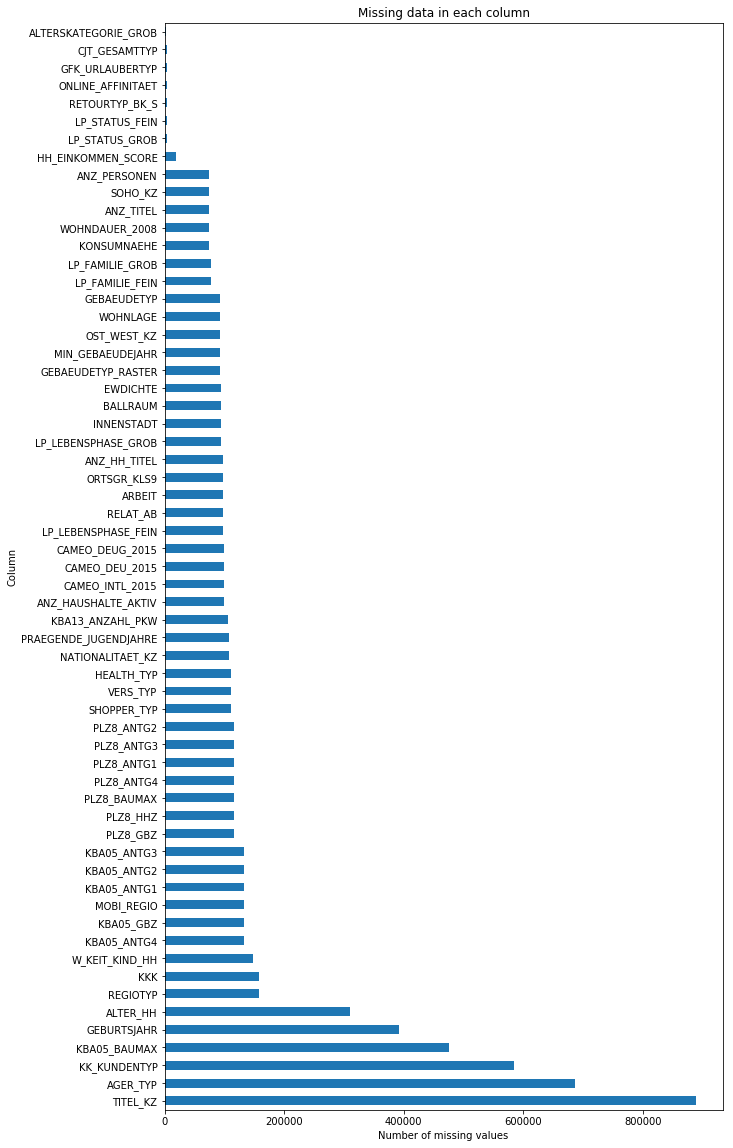

In [15]:
# Investigate patterns in the amount of missing data in each column.

missing_data.plot.barh(figsize=(10, 20))
plt.title("Missing data in each column")
plt.xlabel("Number of missing values")
plt.ylabel("Column")
plt.show()

In [16]:
# percentage of missing values

missing_data_percent = (missing_data / len(azdias)) * 100

# columns missing more than 20% of their data

print("Columns missing more than 20 % of data\n")
print(missing_data_percent[missing_data_percent > 20])

Columns missing more than 20 % of data

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64


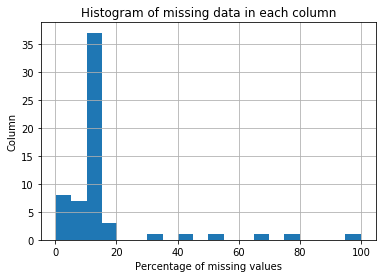

In [17]:
# distribution of missing data percentages

plt.hist(missing_data_percent, bins=20)
plt.title("Histogram of missing data in each column")
plt.xlabel("Percentage of missing values")
plt.ylabel("Column")
plt.grid(True)
plt.show()

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# we will drop the columns that have more than 30 percent of data missing
outlier_columns = missing_data_percent[missing_data_percent> 30].index
outlier_columns

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [19]:
# Drop the outlier columns (columns with more than 30% missing data)
azdias.drop(columns=outlier_columns, inplace=True)

# Check the cleaned dataframe
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The following columns were removed as it has more than 30 percent of missing data.

- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH


There could be a pattern where demographic attributes like title and age type data are the most affected by missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?

missing_data_rows = azdias.isna().sum(axis=1)

# Summart statistics of missing row data
missing_data_rows.describe()

count    891221.000000
mean          5.648638
std          13.234726
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

75% of the rows are missing 3 or fewer missing coulmns. We will set out threshold at 10%, as anything more than can be considered outliers.

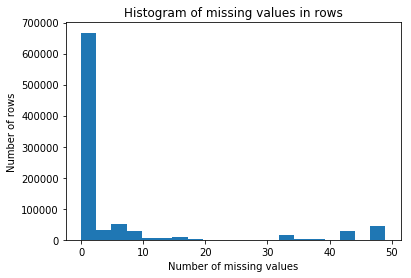

In [21]:
# Distribution of missing values in rows

missing_data_rows.plot.hist(bins=20)
plt.title("Histogram of missing values in rows")
plt.xlabel("Number of missing values")
plt.ylabel("Number of rows")
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 10
data_above_threshold = azdias[missing_data_rows > threshold]
data_below_threshold = azdias[missing_data_rows <= threshold]

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Create a function to compare distribution of missing values
def compare_distribution(column):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    # plot for subset above threshold
    ax1.set_title(f"More than {threshold} missing values")
    sns.countplot(data=data_above_threshold, x=column, ax=ax1)
    ax1.set_xlabel(column)
    ax1.set_ylabel("Count")
    
    # plot for subset below threshold
    ax2.set_title(f"Less than or equal to {threshold} missing values")
    sns.countplot(data=data_below_threshold, x=column, ax=ax2)
    ax2.set_xlabel(column)
    ax2.set_ylabel("Count")
    
    plt.show()

In [24]:
# first 5 columns with no missing values

no_missing_columns = azdias.columns[azdias.isna().sum() == 0][:5]
no_missing_columns

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER'],
      dtype='object')

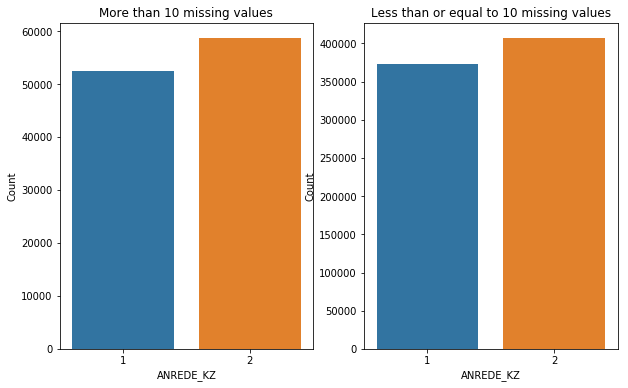

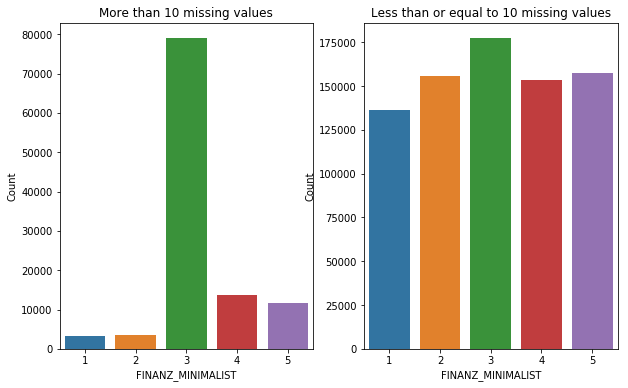

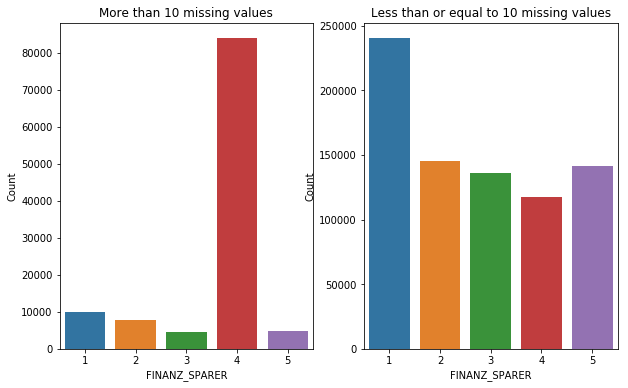

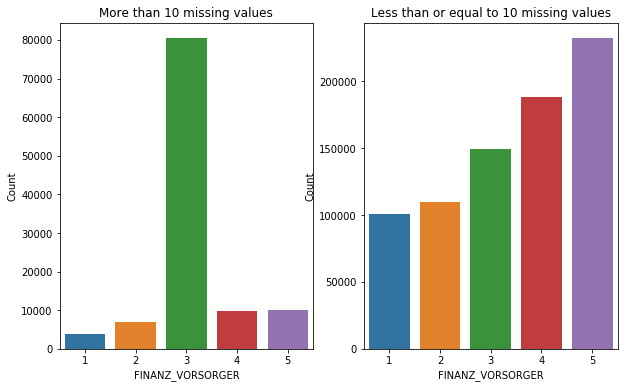

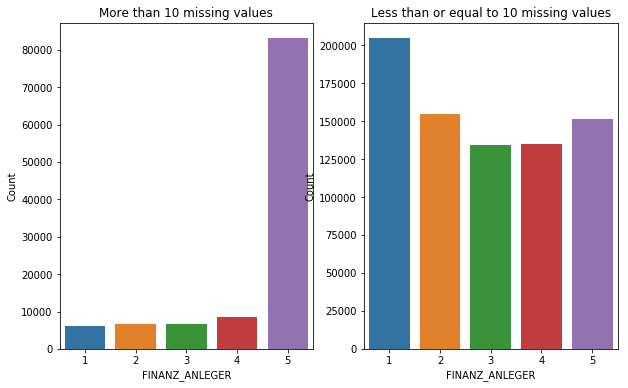

In [25]:
# Compare the missing data distribution for the 5 columns

for column in no_missing_columns:
    compare_distribution(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The plot for rows missing more than 10 values is on the left. And the plot for rows missing 10 or less values is on the right. On comparison, we can see that other than the ANREDE_KZ column, the subset of data with 10 or more missing values is smaller. And, the subset of data with 10 or less than missing values makes the significant portion of the dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?

features = feat_info["type"].value_counts()
features

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# get categorical columns from feat_info
categorical_cols = feat_info[feat_info["type"] == "categorical"]["attribute"]

binary = []          
multi_level = []     
binary_non_num = [] 

# Iterating through each categorical column
for col in categorical_cols:
    # check if column is in the data_below_threshold DataFrame
    if col in data_below_threshold.columns:
        unique_count = data_below_threshold[col].nunique()
        
        # check for binary features
        if unique_count == 2:
            binary.append(col)
            # check for binary non-numeric types
            if data_below_threshold[col].dtype == "object":
                binary_non_num.append(col)
        # Check for multi-level categorical features
        elif unique_count > 2:
            multi_level.append(col)


In [28]:
# binary, multi-level
print(f"Binary features: {binary}\n")
print(f"Binary non-numeric: {binary_non_num}\n")
print(f"Multi-level categorical features: {multi_level}")

Binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Binary non-numeric: ['OST_WEST_KZ']

Multi-level categorical features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

# dropping multi-level categorical variables
data_below_threshold = data_below_threshold.drop(columns=multi_level)

# re-encoding the non numeric binary varible to numeric
data_below_threshold['OST_WEST_KZ'] = data_below_threshold['OST_WEST_KZ'].map({"W": 0, "O": 1})


In [30]:
# check encoding of 'OST_WEST_KZ'
data_below_threshold['OST_WEST_KZ'].unique()

array([0, 1])

In [31]:
data_below_threshold['OST_WEST_KZ'].dtype

dtype('int64')

In [32]:
# check the dataset
data_below_threshold.shape

(780182, 66)

In [33]:
data_below_threshold.shape

(780182, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

- For the categorical features, we kept the five binary features, ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, 
- The one non-numeric OST_WEST_KZ was re-encoded to numeric. 
- We also decided to drop the 12 multi-level categorical features for our analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

1.18. PRAEGENDE_JUGENDJAHRE: 
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

- Mainstream (0): 1, 3, 5, 8, 10, 12, 14. 
- Avantgarde (1): 2, 4, 6, 7, 9, 11, 13, 15

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# movement (binary type)
movement = {1:0, 2:1, 3:0, 4: 1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
data_below_threshold["MOVEMENT"] = data_below_threshold["PRAEGENDE_JUGENDJAHRE"].replace(movement)

# decade (interval type)
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
data_below_threshold["DECADE"] = data_below_threshold["PRAEGENDE_JUGENDJAHRE"].replace(decade)


In [35]:
data_below_threshold[["MOVEMENT", "DECADE"]].head()

,MOVEMENT,DECADE
1,0.0,6.0
2,1.0,6.0
3,0.0,4.0
4,0.0,4.0
5,0.0,2.0


4.3. CAMEO_INTL_2015 : 
German CAMEO: Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [36]:
# Investigate "CAMEO_INTL_2015"
data_below_threshold["CAMEO_INTL_2015"].dtype

dtype('O')

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# converting "CAMEO_INTL_2015" to numeric
data_below_threshold["CAMEO_INTL_2015"] = pd.to_numeric(data_below_threshold["CAMEO_INTL_2015"], errors="coerce")
# creating "WEALTH" variable - by tens place
data_below_threshold["WEALTH"] = data_below_threshold["CAMEO_INTL_2015"].apply(lambda x: x // 10 if x != -1 else -1)

# creating "LIFE_STAGE" variable - by ones place
data_below_threshold["LIFE_STAGE"] = data_below_threshold["CAMEO_INTL_2015"].apply(lambda x: x % 10 if x != -1 else -1)

In [38]:
data_below_threshold[["WEALTH", "LIFE_STAGE"]].head()

,WEALTH,LIFE_STAGE
1,5.0,1.0
2,2.0,4.0
3,1.0,2.0
4,4.0,3.0
5,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

- For the mixed-values features of PRAEGENDE_JUGENDJAHRE, we created two new variables MOVEMENT (0- mainstream or 1 - avantgrade) and DECADE as of interval type. 


- For CAMEO_INTL_2015, two new ordinal variables were created WEALTH - extracted from the tens place and LIFE_STAGE from ones place. Also, we dropped the original PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Dropping the PRAEGENDE_JUGENDJAHRE column
data_below_threshold = data_below_threshold.drop(columns= "PRAEGENDE_JUGENDJAHRE")

# Dropping CAMEO_INTL_2015
data_below_threshold = data_below_threshold.drop(columns= "CAMEO_INTL_2015")


In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

data_below_threshold.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
SOHO_KZ                  float64
VERS_TYP                 float64
ANZ_PERSONEN             float64
ANZ_TITEL 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # creating a copy of the dataframe
    df =df.copy()
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for attribute, missing_index in zip(feat_info["attribute"], feat_info["missing_or_unknown"]):
        missing_values = missing_index.strip("[]").split(",")
        missing_values = [int(value) for value in missing_values if value.strip() not in ["X", "XX", ""]]
        # replacing missing values with Nan
        df.loc[:,attribute] = df[attribute].replace(missing_values, np.nan)
    
    
    # remove selected columns and rows, ...
    
    # removing columns with more than 30 % of missing data
    missing_data_percent = df.isna().sum()/df.shape[0] * 100
    outlier_columns = missing_data_percent[missing_data_percent > 30].index
    df.drop(columns=outlier_columns, inplace=True)
    
    # removing rows with excessive missing data
    missing_data_rows = df.isna().sum(axis=1)
    df = df[missing_data_rows <=10]
    
    # select, re-encode, and engineer column values.
    
    # re-encode binary variables
    df.loc[:, 'OST_WEST_KZ'] = df['OST_WEST_KZ'].map({"W": 0, "O": 1})
    
    # dropping multi-level categorical variables
    categorical_cols = feat_info[feat_info["type"] == "categorical"]["attribute"].tolist()
    multi_level = [col for col in categorical_cols if col in df.columns and df[col].nunique() > 2]
    df = df.drop(columns=multi_level, errors="ignore")
    
    # Engineering Mixed-Type Features - PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015

    # create two variables an interval-type variable for decade, and a binary variable for movement.
    movement = {1:0, 2:1, 3:0, 4: 1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df.loc[:,"MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].replace(movement)
    
    # decade (interval type)
    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df.loc[:,"DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].replace(decade)

    # create two variables 'tens'-place and 'ones'-place digits into two new ordinal variables
    df["CAMEO_INTL_2015"] = pd.to_numeric(df["CAMEO_INTL_2015"], errors="coerce")
    df.loc[:, "WEALTH"] = df["CAMEO_INTL_2015"].apply(lambda x: x // 10 if x != -1 else -1)
    df.loc[:, "LIFE_STAGE"] = df["CAMEO_INTL_2015"].apply(lambda x: x % 10 if x != -1 else -1)
    
    # drop original "PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015" columns
    df.drop(columns=["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], inplace=True, errors="ignore")
    
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# load data
df = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

In [43]:
# apply clean_data function 

df = clean_data(df)

In [44]:
df.shape

(780182, 68)

In [45]:
# check for null values

print("Total Nan values:", df.isnull().sum().sum())

Total Nan values: 627960


We still have 627960 null values in our clean dataset. We will replace the missing values with median values.

In [46]:
# columns with missing values
azdias_missing_cols = data_below_threshold.columns[data_below_threshold.isna().any()]
azdias_missing_cols

Index(['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ',
       'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'MOVEMENT', 'DECADE',
       'WEALTH', 'LIFE_STAGE'],
      dtype='object')

In [47]:
print("Total number of missing columns:", len(azdias_missing_cols))

Total number of missing columns: 38


In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# imputing remaining missing values

imputer = SimpleImputer(missing_values=np.nan, strategy="median")
df[azdias_missing_cols] = imputer.fit_transform(df[azdias_missing_cols])

In [49]:
# check for null values - after imputation

print("Nan values after imputation:", df.isnull().sum().sum())

Nan values after imputation: 0


Successfully replaced all the missing values with median values. Now we can proceed with feature scaling.

In [50]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [51]:
df_scaled.shape

(780182, 68)

In [52]:
df_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,-1.767659,0.958395,-1.488163,1.539083,-1.045234,1.467266,0.980039,1.326901,-0.531198,1.088918,0.412214,0.317544,-1.682504,0.434470,-0.057436,0.005085,-0.454630,-1.685169,-1.120975,-1.436711,-0.583195,1.277548,-0.306362,1.336374,-0.157888,1.506007,1.290973,10.870434,0.916494,0.229641,-0.060807,1.011809,-0.680161,0.553966,0.165121,-0.125737,-1.299654,-0.391271,-0.518771,-0.032795,-1.067835,-1.025057,-0.603097,2.699443,-1.644991,0.847886,-0.552836,1.704187,-0.796827,-0.786190,-1.396833,0.180515,-0.852137,1.019317,-0.258320,0.21327,0.406430,0.410224,-0.642590,1.426835,0.563762,-0.174140,-0.132840,0.679565,-0.531198,1.176164,1.177320,-1.260671
1,0.198090,0.958395,-1.488163,0.866538,-1.771590,-0.569049,0.262516,1.326901,1.882537,1.088918,-1.099149,-1.043725,-0.306531,-0.080353,-1.629545,-0.518467,-0.454630,-0.137110,-0.168853,0.751923,-0.583195,0.068655,1.408781,1.336374,1.446598,-0.632820,-0.410677,-0.091993,-1.091115,-0.633116,-0.060807,-0.285164,-0.680161,0.553966,0.101390,-0.125737,1.282114,-0.391271,-0.518771,-1.071646,-0.345821,1.420826,0.393099,-0.469659,-0.116685,-0.982475,0.029416,-0.266602,0.287819,-0.786190,0.025313,-0.464039,-1.415584,0.277122,0.775269,0.21327,-0.611392,-0.970632,-0.642590,0.395229,0.563762,-0.174140,-0.132840,-0.795502,1.882537,1.176164,-0.873434,0.760364
2,1.180964,0.958395,0.688900,-0.478551,1.133836,-0.569049,-1.172531,-0.817842,-0.531198,-0.263470,-0.259502,-0.499218,-0.994518,0.434470,-1.629545,-1.042020,-1.499848,-0.137110,-0.168853,1.299081,-0.072190,-0.535792,-0.306362,-0.308998,0.376941,-0.098113,0.156540,-0.091993,-1.091115,-1.495873,-0.060807,-2.230623,-0.095262,0.553966,-0.472184,-0.125737,0.636672,1.584108,-0.518771,1.525480,1.820223,-0.209763,-0.603097,-0.469659,0.647467,-0.067295,-1.135088,0.718792,0.287819,0.269832,0.736386,-1.108592,0.274758,-0.065885,-0.258320,-0.87869,0.406430,-0.970632,-0.642590,-0.636378,0.563762,-1.179810,-1.003716,-0.057969,-0.531198,-0.217971,-1.557019,-0.586992
3,0.198090,-1.043411,0.688900,0.193993,0.407479,-1.247820,0.262516,-0.817842,-0.531198,1.088918,1.335825,1.406559,1.069441,0.949293,-0.057436,0.005085,-0.977239,1.410949,-0.168853,-0.342394,0.949819,-1.140239,-0.878077,-1.405913,-1.227545,-0.098113,-0.977893,-0.091993,0.916494,1.955156,-0.060807,0.363323,-1.265061,0.553966,-0.344723,-0.125737,0.636672,-0.391271,-0.518771,-0.552220,-0.345821,2.236121,0.393099,-0.469659,-0.116685,-0.982475,0.611668,-1.744693,1.372464,0.269832,0.025313,1.469621,0.274758,-0.541954,-0.258320,1.30523,0.406430,0.410224,0.044309,-0.636378,-0.339947,0.831529,0.302598,1.417098,-0.531198,-0.217971,0.493736,0.086686
4,-1.767659,0.958395,-0.036788,-1.151096,1.133836,-0.569049,-0.455008,1.326901,-0.531198,1.088918,-0.679326,-0.771472,-0.306531,-1.109999,-0.057436,1.575743,0.067980,-1.169150,-1.120975,-1.436711,0.438814,1.881994,-0.306362,-0.308998,-0.157888,1.506007,1.290973,-0.091993,0.916494,-0.633116,-0.060807,0.363323,1.074537,0.553966,-0.217262,-0.125737,1.282114,-0.391271,-0.518771,1.525480,0.376194,0.605532,-0.603097,-0.469659,0.647467,0.847886,-1.135088,1.211490,0.287819,1.325854,0.736386,-1.108592,0.274758,2.015810,-0.258320,0.21327,-0.611392,0.4102

### Discussion 2.1: Apply Feature Scaling

We implemented the clean_data function to clean the dataset. After cleaning the dataset we opted for imputation and replaced the remaining missing values with median values. And, applied feature scaling by using Standard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA to the data.

pca = PCA()
pca.fit(df_scaled)

PCA()

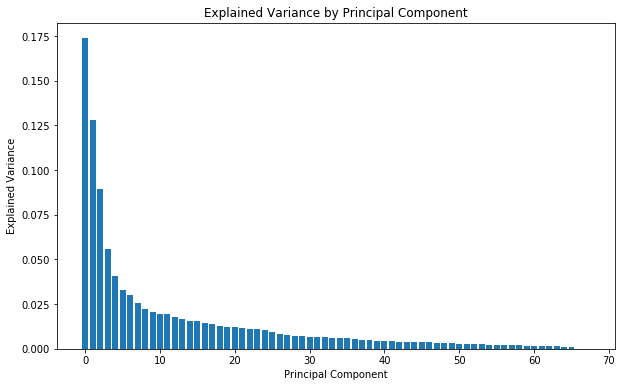

In [54]:
# Investigate the variance accounted for by each principal component.

# explained variance
num_components = np.arange(len(pca.explained_variance_ratio_))
exp_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.bar(num_components, exp_variance)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance by Principal Component")
plt.show()

Text(0.5,1,'Cumulative explained variance by Principal Component')

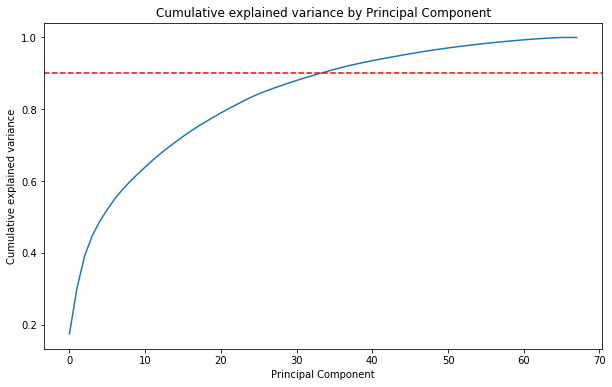

In [55]:
# cumulative explained variance

cum_exp_variance = np.cumsum(exp_variance)

plt.figure(figsize=(10,6))
plt.plot(num_components, cum_exp_variance)
plt.axhline(y=0.90, color="r", linestyle="--")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance by Principal Component")

In [56]:
# compute number of components to retain

num_retain = np.argmax(cum_exp_variance > 0.90) + 1
print(num_retain)

35


In [57]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=num_retain)
final_pca = pca.fit_transform(df_scaled)

In [58]:
# check the final_pca

final_pca.shape

(780182, 35)

In [59]:
print(pca.explained_variance_ratio_.sum())

0.9051302978151763


Hence, after retaining 35 components we get a total variance of 0.905135753745563 (90.5% approx)

### Discussion 2.2: Perform Dimensionality Reduction

Using PCA we reduced the dimensionality of the data to 35 and got 90.5% of cumulative variance. Hence we will continue with it as on retaining 35 principal components we got approximately 90.5% of cumulative  variance in the data.

References:

https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/

https://www.baeldung.com/cs/pca


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(df, pca, component_index):
    
    weights = pca.components_[component_index]
    weights_df = pd.DataFrame(weights, index=df.columns, columns=["Weight"])
    # sort the dataframe by weights
    sorted_weights = weights_df.sort_values(by="Weight", ascending=False)
    
    return sorted_weights

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

first_component = map_weights(df_scaled, pca, 0)
print(first_component)

                         Weight
PLZ8_ANTG3             0.224217
PLZ8_ANTG4             0.218429
PLZ8_BAUMAX            0.212969
WEALTH                 0.200909
HH_EINKOMMEN_SCORE     0.197226
ORTSGR_KLS9            0.196699
EWDICHTE               0.194470
FINANZ_HAUSBAUER       0.164460
KBA05_ANTG4            0.152335
PLZ8_ANTG2             0.152267
ARBEIT                 0.141254
ANZ_HAUSHALTE_AKTIV    0.133879
KBA05_ANTG3            0.133266
RELAT_AB               0.133065
FINANZ_SPARER          0.115429
SEMIO_PFLICHT          0.086149
SEMIO_REL              0.083230
SEMIO_RAT              0.070605
DECADE                 0.070108
REGIOTYP               0.063479
SEMIO_TRADV            0.061546
SEMIO_MAT              0.060549
SEMIO_FAM              0.059952
W_KEIT_KIND_HH         0.055943
OST_WEST_KZ            0.053593
SEMIO_KULT             0.050159
FINANZ_UNAUFFAELLIGER  0.049615
SEMIO_KAEM             0.043172
FINANZ_ANLEGER         0.042735
PLZ8_HHZ               0.041796
ANZ_HH_T

For First principal component

- Positive weights: PLZ8_ANTG3 (0.224217), PLZ8_ANTG4 (0.218429), PLZ8_BAUMAX (0.212969)
- Negative weights: MOBI_REGIO (-0.236225), PLZ8_ANTG1 (-0.223760), KBA05_ANTG1 (-0.216795)

In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_component = map_weights(df_scaled, pca, 1)
print(second_component)

                         Weight
ALTERSKATEGORIE_GROB   0.271870
FINANZ_VORSORGER       0.244090
SEMIO_ERL              0.235628
SEMIO_LUST             0.190258
RETOURTYP_BK_S         0.165132
W_KEIT_KIND_HH         0.116183
SEMIO_KRIT             0.113265
SEMIO_KAEM             0.103393
FINANZ_MINIMALIST      0.094618
FINANZ_HAUSBAUER       0.093790
ANREDE_KZ              0.085504
EWDICHTE               0.067639
ORTSGR_KLS9            0.066419
WOHNDAUER_2008         0.065437
SEMIO_DOM              0.064640
PLZ8_ANTG3             0.064591
PLZ8_ANTG4             0.061490
PLZ8_BAUMAX            0.056369
KBA05_ANTG4            0.050008
ARBEIT                 0.048194
RELAT_AB               0.046932
WEALTH                 0.045347
PLZ8_ANTG2             0.044867
ANZ_HAUSHALTE_AKTIV    0.043777
KBA05_ANTG3            0.027006
VERS_TYP               0.026853
HH_EINKOMMEN_SCORE     0.026316
ANZ_HH_TITEL           0.026286
LIFE_STAGE             0.018174
OST_WEST_KZ            0.017802
PLZ8_HHZ

For second principal component

- Positive Weights: ALTERSKATEGORIE_GROB (0.271870), FINANZ_VORSORGER (0.244090), and SEMIO_ERL (0.235628) have the highest positive weights


- Negative Weights: SEMIO_REL (-0.264952), DECADE (-0.261603) and FINANZ_SPARER (-0.251108) have substantial negative weights.

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_component = map_weights(df_scaled, pca, 2)
print(third_component)

                         Weight
SEMIO_VERT             0.347372
SEMIO_SOZ              0.263384
SEMIO_FAM              0.249914
SEMIO_KULT             0.234703
FINANZ_MINIMALIST      0.161419
RETOURTYP_BK_S         0.106590
FINANZ_VORSORGER       0.099220
W_KEIT_KIND_HH         0.085927
ALTERSKATEGORIE_GROB   0.077470
SEMIO_REL              0.070714
SEMIO_LUST             0.063471
GREEN_AVANTGARDE       0.056374
MOVEMENT               0.056374
SEMIO_MAT              0.055273
ORTSGR_KLS9            0.045113
PLZ8_BAUMAX            0.044241
EWDICHTE               0.044219
PLZ8_ANTG4             0.042218
PLZ8_ANTG3             0.041250
WOHNDAUER_2008         0.033981
ARBEIT                 0.031533
RELAT_AB               0.028899
PLZ8_ANTG2             0.027322
KBA05_ANTG4            0.023343
ANZ_HAUSHALTE_AKTIV    0.020683
WEALTH                 0.019772
OST_WEST_KZ            0.013366
ANZ_HH_TITEL           0.012356
ANZ_TITEL              0.010402
LP_LEBENSPHASE_FEIN    0.007169
VERS_TYP

For the third principal component 

- Positive weights: SEMIO_VERT (0.347372), SEMIO_SOZ (0.263384), SEMIO_FAM   (0.249914)

- Negative weights: ANREDE_KZ (-0.369158), SEMIO_KAEM (-0.338127), SEMIO_DOM (-0.313017)

### Discussion 2.3: Interpret Principal Components

### First principal component

Positive Weights:
- MOBI_REGIO - Movement patterns
- PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region
- KBA05_ANTG1 - Number of 1-2 family houses in the microcell

Negative Weights:
- PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region
- PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
- PLZ8_BAUMAX - Most common building type within the PLZ8 region

*Both positive and negative values highlight mobilty patterns and prefrences in housing.*

### Second principal component

Positive Weights:
- ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
- FINANZ_VORSORGER - Financial typology, for each dimension
- SEMIO_ERL - Personality typology

Negative Weights:
- FINANZ_SPARER - Financial typology
- DECADE - Generation
- SEMIO_REL - Personality typology

*The second component indicates relationship between age, personality and financial topologies.*

### Third principal component

Positive Weights:
- ANREDE_KZ - Gender
- SEMIO_KAEM - Personality typology
- SEMIO_DOM - Personality typology

Negative Weights:
- SEMIO_VERT - Personality typology
- SEMIO_SOZ - Personality typology
- SEMIO_FAM - Personality typology

*The third component focuses on gender and personality, with positive values representing dominating and comabitve attitudes.*

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
# We are using inertia for KMeans clustering, as its simpler 
# and faster than silhouette. Also we are using MiniBatchKMeans

# Over a number of different cluster counts...
cluster_range = np.arange(10, 31)

# store inertia scores
inertia_scores = []

# run k-means clustering on the data and...
for k in cluster_range:
    
    # compute the average within-cluster distances.
    mbkmeans = MiniBatchKMeans(n_clusters = k, batch_size = 100, random_state = 42)
    mbkmeans.fit(final_pca)
    
    #score = silhouette_score(final_pca, kmeans.labels_)
    
    # store inertia for current clusters
    inertia_scores.append(mbkmeans.inertia_)
    

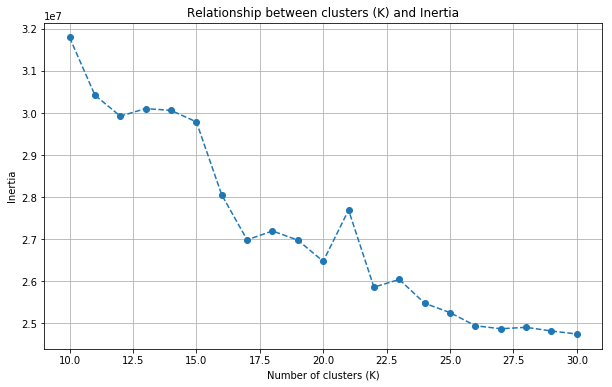

In [65]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_scores, marker="o", linestyle="--")

plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Relationship between clusters (K) and Inertia")
plt.grid(True)
plt.show()


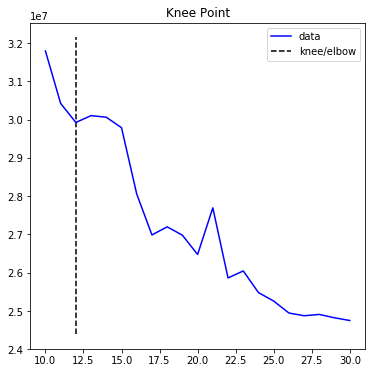

In [66]:
# using the kneelocator to find the knee point

k1 = KneeLocator(cluster_range, inertia_scores, curve="convex", direction="decreasing")
k1.plot_knee()
plt.show()

In [67]:
# find the optimal number of clusters

k1.elbow

12

In [68]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

mbkmeans = MiniBatchKMeans(n_clusters=13, batch_size=100, random_state=42)
mbkmeans = mbkmeans.fit(final_pca)
# get the cluster predictions
mbkmeans_pred = mbkmeans.predict(final_pca)

### Discussion 3.1: Apply Clustering to General Population

We used MiniBatchKMeans for clustering because of its speed and efficiecy. Inplace of silhouette score, we computed inertia, as its faster and simpler.Also, we used the elbow method and Kneelocator to determine the optimal number of segments would be 12. And, finally we refitted the model with 12 clusters.


*References:*

https://realpython.com/k-means-clustering-python/

https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [69]:
# Load in the customer demographics data.
customers =  pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [70]:
customers.shape

(191652, 85)

In [71]:
# Cleaning the dataset
cleaned_customers = clean_data(customers)

In [72]:
cleaned_customers.shape

(139278, 66)

In [73]:
# Total Nan values in cleaned customers dataset

print("Total NaN values in cleaned cutomers:", cleaned_customers.isna().sum().sum())

Total NaN values in cleaned cutomers: 74429


In [74]:
# columns with missing values

cust_missing_cols = cleaned_customers.columns[cleaned_customers.isna().any()]
cust_missing_cols

Index(['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
       'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB', 'MOVEMENT', 'DECADE', 'WEALTH',
       'LIFE_STAGE'],
      dtype='object')

In [75]:
print(len(cust_missing_cols))

35


In [76]:
# find the columns with missing data that are not in cleaned customers

set(azdias_missing_cols) - set(cust_missing_cols)

{'GEBAEUDETYP_RASTER', 'KKK', 'REGIOTYP'}

In [77]:
# assign the missing with nan values - we are imputing all nan values

cleaned_customers['GEBAEUDETYP_RASTER'] = np.nan
cleaned_customers['KKK'] = np.nan
cleaned_customers['REGIOTYP'] = np.nan

In [79]:
cust_missing_cols = cleaned_customers.columns[cleaned_customers.isna().any()]
cust_missing_cols

Index(['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'MOVEMENT', 'DECADE', 'WEALTH',
       'LIFE_STAGE', 'KKK', 'REGIOTYP'],
      dtype='object')

In [80]:
print(len(cust_missing_cols))

38


In [81]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# impute Nan values - cleaned customers
cleaned_customers[cust_missing_cols] = imputer.transform(cleaned_customers[cust_missing_cols])

In [82]:
# Apply scaling

scaled_customers = scaler.transform(cleaned_customers)
scaled_customers_df = pd.DataFrame(scaled_customers, columns=cleaned_customers.columns)

In [83]:
# applying PCA transforamtion

pca_customers = pca.transform(scaled_customers_df)

In [84]:
# KMeans prediction

mbkmeans_customers = mbkmeans.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

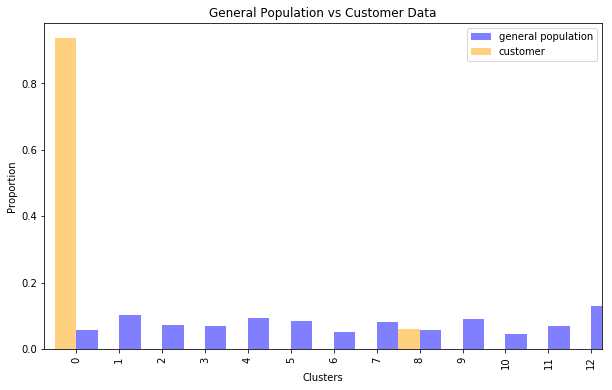

In [85]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gen_prop = pd.Series(mbkmeans_pred).value_counts(normalize=True).sort_index()
cust_prop = pd.Series(mbkmeans_customers).value_counts(normalize=True).sort_index()

# plotting the proportions for general population and customer data

plt.figure(figsize=(10, 6))
gen_prop.plot(kind="bar", alpha=0.5, label="general population", color="blue", position=0)
cust_prop.plot(kind="bar", alpha=0.5, label="customer", color="orange", position=1)

plt.title("General Population vs Customer Data")
plt.xlabel("Clusters")
plt.ylabel("Proportion")
plt.legend()
plt.show()

In [86]:
# comparing all of the overrepresented clusters

combined_props = cust_prop.reindex(gen_prop.index, fill_value=0)
diff = combined_props - gen_prop
over_clusters = diff[diff > 0].sort_values(ascending=False)

over_clusters

0    0.878575
8    0.004563
dtype: float64

Cluster 0 is the most overrepresented cluster

In [87]:
# underrepresented clusters

under_clusters = diff[diff< 0].sort_values()
under_clusters

12   -0.128750
1    -0.100851
4    -0.093514
9    -0.091706
5    -0.084857
7    -0.079319
2    -0.071875
11   -0.069180
3    -0.069122
6    -0.050270
10   -0.043695
dtype: float64

Cluster 12 is the most underrepresented cluster

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# creating a series of centroid data
centroid_0 = scaler.inverse_transform(pca.inverse_transform(mbkmeans.cluster_centers_[0].reshape(1, -1)))
centroid_0_s = pd.Series(data=centroid_0.flatten(), index=cleaned_customers.columns)
centroid_0_s

Following are the few key characteristics that can help us determine the kind of people that are part of cluster 0 (overrepresented)


- ALTERSKATEGORIE_GROB - 1.559802 : individuals less than 30 years old
- ANREDE_KZ - 0.936707 : male
- FINANZ_MINIMALIST - 4.052014 : low financial minimalism
- FINANZ_SPARER - 4.272077 : low affinity towards saving money
- FINANZ_ANLEGER - 3.953435 : average affinity in investor
- FINANZ_HAUSBAUER - 2.645735 : home owner
- SEMIO_SOZ- 6.920100 : very low affinity in socially mindedness
- SEMIO_FAM - 6.780693 : very low affinity towards family orientation
- SEMIO_REL - 6.846271 : very low affinity to religious values
- SEMIO_KULT -  7.064099 : lowest affinity cultural mindedness
- SEMIO_DOM - 2.125845 : very high affinity on dominance
- HH_EINKOMMEN_SCORE - 3.737011 : high household net income
- ONLINE_AFFINITAET - 3.865368 : high online activity
- EWDICHTE -  3.154722 : live in a moderate population density area
- LP_LEBENSPHASE_FEIN - 20.082020 : top earner couples of higher age
- LP_LEBENSPHASE_GROB - 6.127578 : single parents

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# creating a series of centroid data
centroid_12 = scaler.inverse_transform(pca.inverse_transform(mbkmeans.cluster_centers_[12].reshape(1, -1)))

centroid_12_s = pd.Series(data=centroid_12.flatten(), index=cleaned_customers.columns)
centroid_12_s

Following are the few key characteristics that can help us determine the kind of people that are part of cluster 12 (underrepresented)

- ALTERSKATEGORIE_GROB - 3.340625 : aged between 46 - 60 years old
- ANREDE_KZ - 1.067996 : male 
- FINANZ_MINIMALIST - 4.905086 : low on financial minimalist behavior
- FINANZ_SPARER - 1.575153 : very high on money saving behavior
- FINANZ_ANLEGER - 1.899686 : very high on investing 
- FINANZ_HAUSBAUER - 1.745198 : very high likelyhood of being home owner
- SEMIO_SOZ- 4.762612 : average on socially mindedness
- SEMIO_FAM - 4.740353 : average on family orientation
- SEMIO_REL - 3.699552 : high on being religious values
- SEMIO_KULT - 4.893093 : average affinity on cultural activities
- SEMIO_DOM - 3.133177 : high affinity on dominant attitudes
- HH_EINKOMMEN_SCORE - 3.018975 : belong to high household income category
- ONLINE_AFFINITAET - 4.201053 : very high affinity for online activities
- EWDICHTE - 2.801566 : live in a low dense populated areas
- LP_LEBENSPHASE_FEIN - 23.771989 : single parent high-income earners
- LP_LEBENSPHASE_GROB - 6.978038 : single parents

### Discussion 3.3: Compare Customer Data to Demographics Data


- Popular segment (cluster 0): This cluster consists of mostly males that are under 30 years of age. The individuals in this cluster have high household incomes and are likley homeowners. They have high affinity towards online activity and are very dominant in nature. Also, they have very low affinty for social, family or religious values. It seems that the company's offerings and products are of great appeal to this demographic.


- Unpopular segment (cluster 12):  The underrepresented cluster consists of males aged between 46- 60 years. These individuals have high household income and have high affinity towards saving money and investments. They reside in low-density areas and very much engaged online. They are more family, socially and religiously oriented compared to individuals in the popular segment.It is possible that the company's offerings may not align with the needs of the individuals on the unpopular segment.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.